In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Filter out FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/'

Mounted at /content/drive
/content/drive/My Drive


In [3]:
#data cleaning

dataset = pd.read_csv('stroke_data_cleaned.csv')
print("***")
print(dataset.head(5))
print("***")
print(dataset.dtypes)
print("***")
#check for NA values
print(dataset.isna().sum())
print("***")
#describe with int values, otherwise gives me floats
print(dataset.describe())
#fill the missing valeus for bmi with the values from bmi_imp
dataset["bmi"].fillna(dataset["bmi_imp"], inplace=True)
print(dataset)
#check if any values na -> good result
print(dataset.isna().sum())

####data cleaned

print("***************************************************************")


***
   Unnamed: 0  gender   age  hypertension  heart_disease ever_married  \
0           0    Male  67.0             0              1          Yes   
1           1  Female  61.0             0              0          Yes   
2           2    Male  80.0             0              1          Yes   
3           3  Female  49.0             0              0          Yes   
4           4  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  bmi_imp smoking_status_imp  rounded_age  
0       1     36.6    formerly smoked    

if gender equals Male, the probality to have a stroke is 5.11 %
if gender equals Female, the probality to have a stroke is 4.71 %
if gender equals Other, the probality to have a stroke is 0.0 %
*******************************
if ever_married equals Yes, the probality to have a stroke is 6.56 %
if ever_married equals No, the probality to have a stroke is 1.65 %
*******************************
if work_type equals Private, the probality to have a stroke is 5.09 %
if work_type equals Self-employed, the probality to have a stroke is 7.94 %
if work_type equals Govt_job, the probality to have a stroke is 5.02 %
if work_type equals children, the probality to have a stroke is 0.29 %
if work_type equals Never_worked, the probality to have a stroke is 0.0 %
*******************************
if Residence_type equals Urban, the probality to have a stroke is 5.2 %
if Residence_type equals Rural, the probality to have a stroke is 4.53 %
*******************************
if smoking_status equals formerly 

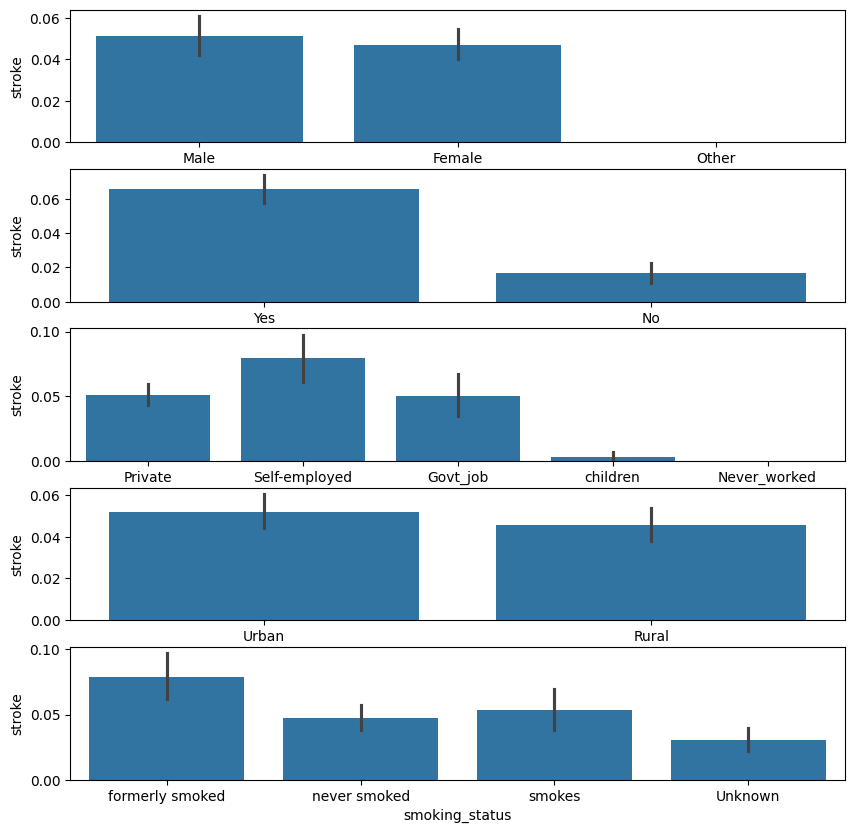

****************************************


In [4]:
#EDA part improved --> aim to discover the data better

#see the effect (in simple terms) of the categorical variables on strokes
#object indicates the categorical variables basically
for cat in dataset.select_dtypes("object"):
    #this iterates throguh every value in the column and picks all possible valeus that cateogry can take
    for val in dataset[cat].unique():
        #take that category and see what the average number of strokes for that cateogry is
        p=(dataset[dataset[cat] == val].stroke.mean())*100
        print("if {0} equals {1}, the probality to have a stroke is {2} %".format(cat, val, round(p,2)))

    print("*******************************")

#see the distribution of the cateogical variables  as a measure for the spread/distirbution of the data
categories = dataset.select_dtypes("object").columns.tolist()
print(categories)
#drop impured smpking status
dataset.drop("smoking_status_imp",axis=1,inplace=True)
f,axes=plt.subplots(nrows=5, ncols=1,figsize=(10,10))

#include enumerate to get the indices of the plots
for index,category in enumerate(dataset.select_dtypes("object")):
    sns.barplot(x=category, y="stroke", data=dataset,ax=axes[index])

plt.show()

print("****************************************")

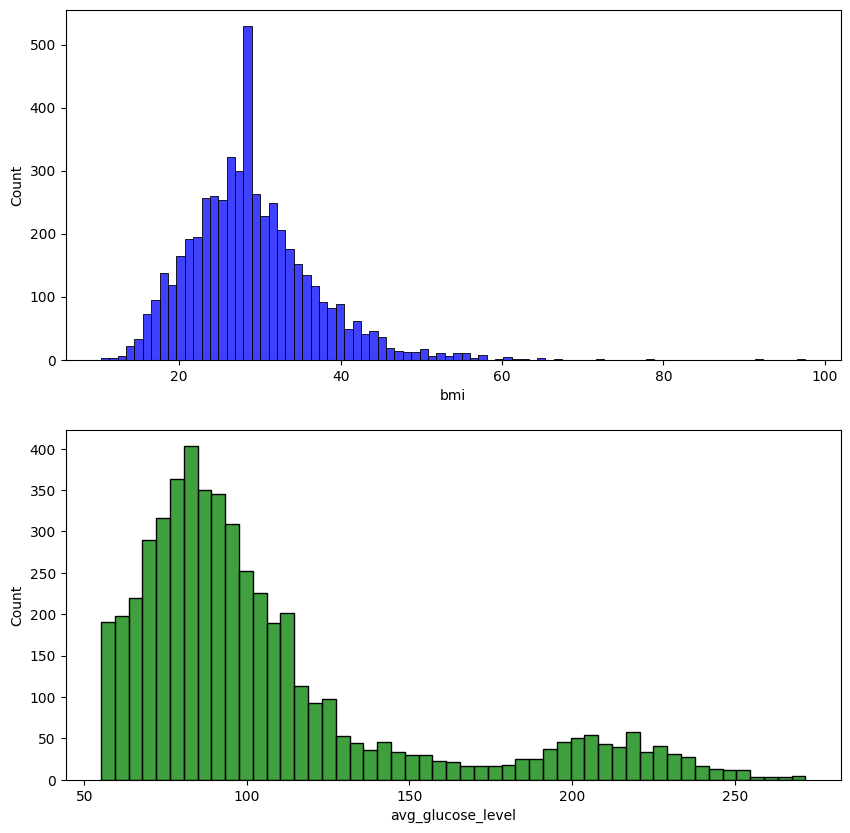

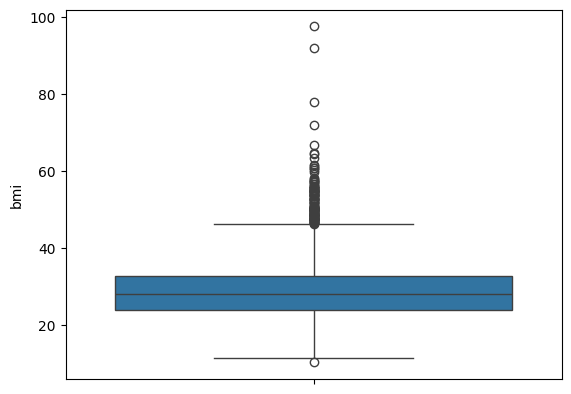

5.0 % , 95.0 %
**********************************************


In [13]:
#to not exclude see the distribution and variacne of the continous variables
f, axes = plt.subplots(2,1,figsize=(10,10))
sns.histplot(dataset["bmi"], color="blue", ax=axes[0])
sns.histplot(dataset["avg_glucose_level"], color="green",ax=axes[1])
plt.show()
#plot boxplots
sns.boxplot(dataset["bmi"])
plt.show()


#see the percentual distribution of the target variable stroke
positive = dataset[dataset["stroke"]==1].shape[0]
negative = dataset[dataset["stroke"]==0].shape[0]
positive = positive/len(dataset)
negative = negative/len(dataset)
print(round(positive*100,0), "% ,",round(negative*100,0), "%")

#this way we state how does our imbalanced dataset look like

print("**********************************************")


In [58]:
#avoid introducing spurious ordinality, so better use onehot
#encoder for encoding the variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# define the columns to encode with one hot encoder
end_col_onehot = ["gender", "smoking_status", "work_type"]
#initialize a new dataset, profit later visible
dataset_encoded = dataset

for col in end_col_onehot:
  one_hot = pd.get_dummies(dataset_encoded[col])
  dataset_encoded = dataset_encoded.drop(col, axis=1)
  dataset_encoded = dataset_encoded.join(one_hot)

#drop the unencoded columns
dataset_encoded = dataset_encoded.iloc[:,1:]
#dataset encoded is a separate dataset because we have to save the encoded variables separately
#in order to decode them as well later...

#encode with Label Encoder the binary variables ( with only 2 entries)
from sklearn.preprocessing import LabelEncoder
#define cols
enc_col_le = ["ever_married", "Residence_type"]
label_encoder = LabelEncoder()
#iterate through cols
for col in enc_col_le:
   dataset_encoded[col] = label_encoder.fit_transform(dataset_encoded[col])

#ever married : 1 yes 0 no .. residence type urban 1, 0 rural
dataset_encoded


,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,bmi_imp,rounded_age,...,Other,Unknown,formerly smoked,never smoked,smokes,Govt_job,Never_worked,Private,Self-employed,children
0,67.0,0,1,1,1,228.69,36.6,1,36.6,67.0,...,0,0,1,0,0,0,0,1,0,0
1,61.0,0,0,1,0,202.21,28.1,1,28.1,61.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,0,1,1,0,105.92,32.5,1,32.5,80.0,...,0,0,0,1,0,0,0,1,0,0
3,49.0,0,0,1,1,171.23,34.4,1,34.4,49.0,...,0,0,0,0,1,0,0,1,0,0
4,79.0,1,0,1,0,174.12,24.0,1,24.0,79.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1,0,1,1,83.75,28.1,0,28.1,80.0,...,0,0,0,1,0,0,0,1,0,0
5106,81.0,0,0,1,1,125.20,40.0,0,40.0,81.0,...,0,0,0,1,0,0,0,0,1,0
5107,35.0,0,0,1,0,82.99,30.6,0,30.6,35.0,...,0,0,0,1,0,0,0,0,1,0
5108,51.0,0,0,1,0,166.29,25.6,0,25.6,51.0,...,0,0,1,0,0,0,0,1,0,0


In [60]:
#divide the training data
X = dataset_encoded.drop(['stroke'], axis=1)  # features
y = dataset_encoded['stroke']  # target

# Split the data again into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#standardizing by substracting the mean (normalizing the variable) and unit variance
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [71]:
#define training function
#use pipeline model to scale first and than train
from sklearn.metrics import confusion_matrix
def train_and_evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    #initialize classifier
    clf = classifier(random_state=42)
    #train the classifier
    clf.fit(X_train, y_train)
    #predict the probability on the test set
    y_prob = clf.predict_prob
    #predict on the test set
    predictions = clf.predict(X_test)
    #evaluate the classifier
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    matrix = confusion_matrix(y_test,predictions)

    return accuracy, report, matrix



In [72]:
# Train and evaluate Decision Tree classifier
dt_accuracy, dt_report, dt_matrix = train_and_evaluate_classifier(DecisionTreeClassifier, X_train_std, y_train, X_test_std, y_test)

# Train and evaluate Random Forest classifier
rf_accuracy, rf_report, rf_matrix = train_and_evaluate_classifier(RandomForestClassifier, X_train_std, y_train, X_test_std, y_test)

# Train and evaluate Support Vector Machine classifier
svm_accuracy, svm_report, svm_matrix = train_and_evaluate_classifier(SVC, X_train_std, y_train, X_test_std, y_test)

# Train and evaluate Logistic Regression classifier
logreg_accuracy, logreg_report, logreg_matrix = train_and_evaluate_classifier(LogisticRegression, X_train_std, y_train, X_test_std, y_test)




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
#print results
print("Decision Tree Classifier:")
print("Accuracy:", dt_accuracy)
print("Classification Report:", dt_report)
print("Confusion Matrix:\n", dt_matrix)

print("\nRandom Forest Classifier:")
print("Accuracy:", rf_accuracy)
print("Classification Report:", rf_report)
print("Confusion Matrix:\n", rf_matrix)

print("\nSupport Vector Machine Classifier:")
print("Accuracy:", svm_accuracy)
print("Classification Report:", svm_report)
print("Confusion Matrix:\n", svm_matrix)

print("\nLogistic Regression Classifier:")
print("Accuracy:", logreg_accuracy)
print("Classification Report:", logreg_report)
print("Confusion Matrix:\n", logreg_matrix)

Decision Tree Classifier:
Accuracy: 0.9090019569471625
Classification Report:               precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.14      0.16      0.15        50

    accuracy                           0.91      1022
   macro avg       0.55      0.55      0.55      1022
weighted avg       0.92      0.91      0.91      1022

Confusion Matrix:
 [[921  51]
 [ 42   8]]

Random Forest Classifier:
Accuracy: 0.949119373776908
Classification Report:               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Confusion Matrix:
 [[970   2]
 [ 50   0]]

Support Vector Machine Classifier:
Accuracy: 0.9510763209393346
Classification Report:               prec

SMOTE APPLY 

Data shapes before oversampling were (4088, 21) and (4088,)
Data shapes after oversampling were (7778, 21) and (7778,)
0    3889
1    3889
Name: stroke, dtype: int64


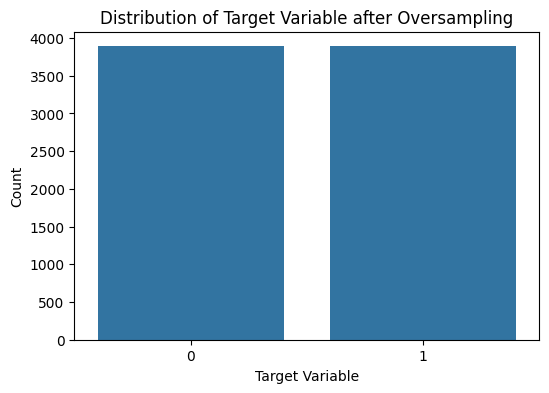

In [74]:
print("SMOTE APPLY \n")
#it makes sence to apply smote because the data is biased and imbalanced which
#may cause biased models at the end which will fail to make accurate predictions

#initiation of smote
oversample = SMOTE(random_state=42)
#fit smote to training sample
X_res, y_res = oversample.fit_resample(X_train_std, y_train)
print('Data shapes before oversampling were {0} and {1}'.format(X_train_std.shape, y_train.shape))
print('Data shapes after oversampling were {0} and {1}'.format(X_res.shape, y_res.shape))
print(y_res.value_counts())

#distribution after oversampling
plt.figure(figsize=(6, 4))
sns.countplot(x=y_res)
plt.title('Distribution of Target Variable after Oversampling')
plt.xlabel('Target Variable')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['0', '1'])  # Optionally, set custom tick labels
plt.show()



In [80]:
from sklearn.metrics import confusion_matrix

# Train and evaluate Decision Tree classifier
dt_accuracy_Smote, dt_report_Smote, dt_matrix_Smote = train_and_evaluate_classifier(DecisionTreeClassifier, X_res, y_res, X_test_std, y_test)

# Train and evaluate Random Forest classifier
rf_accuracy_Smote, rf_report_Smote, rf_matrix_Smote = train_and_evaluate_classifier(RandomForestClassifier, X_res, y_res, X_test_std, y_test)

# Train and evaluate Support Vector Machine classifier
svm_accuracy_Smote, svm_report_Smote, svm_matrix_Smote = train_and_evaluate_classifier(SVC, X_res, y_res, X_test_std, y_test)

# Train and evaluate Logistic Regression classifier
logreg_accuracy_Smote, logreg_report_Smote, logreg_matrix_Smote = train_and_evaluate_classifier(LogisticRegression, X_res, y_res, X_test_std, y_test)




In [83]:
# Print results
print("Decision Tree Classifier:")
print("Accuracy:", dt_accuracy_Smote)
print("Classification Report:\n", dt_report_Smote)
print("Confusion Matrix:\n", dt_matrix_Smote)

print("\nRandom Forest Classifier:")
print("Accuracy:", rf_accuracy_Smote)
print("Classification Report:\n", rf_report_Smote)
print("Confusion Matrix:\n", rf_matrix_Smote)

print("\nSupport Vector Machine Classifier:")
print("Accuracy:", svm_accuracy_Smote)
print("Classification Report:\n", svm_report_Smote)
print("Confusion Matrix:\n", svm_matrix_Smote)

print("\nLogistic Regression Classifier:")
print("Accuracy:", logreg_accuracy_Smote)
print("Classification Report:\n", logreg_report_Smote)
print("Confusion Matrix:\n", logreg_matrix_Smote)

Decision Tree Classifier:
Accuracy: 0.8639921722113503
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       972
           1       0.11      0.24      0.15        50

    accuracy                           0.86      1022
   macro avg       0.53      0.57      0.54      1022
weighted avg       0.92      0.86      0.89      1022

Confusion Matrix:
 [[871 101]
 [ 38  12]]

Random Forest Classifier:
Accuracy: 0.9148727984344422
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       972
           1       0.12      0.12      0.12        50

    accuracy                           0.91      1022
   macro avg       0.54      0.54      0.54      1022
weighted avg       0.91      0.91      0.91      1022

Confusion Matrix:
 [[929  43]
 [ 44   6]]

Support Vector Machine Classifier:
Accuracy: 0.8091976516634051
Classification Report:
               